# Example 14 donor-acceptor_B

**This example takes a while. (a couple of hours)**

- References
  - [Dorfner, Maximilian FX, et al. "Comparison of matrix product state and multiconfiguration time-dependent hartree methods for nonadiabatic dynamics of exciton dissociation." Journal of Chemical Theory and Computation 20.20 (2024): 8767-8781.](https://doi.org/10.1021/acs.jctc.4c00751)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
pytdscf version = 1.0.4
macOS-15.4.1-x86_64-i386-64bit-Mach-O
cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import Exciton, Boson, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian

## Model Hamiltonian

$$
H = H_{\text{ele}} + H_{\text{ph}} + H_{\text{el-ph}}
$$

where $H_{\text{ele}}$ is the electronic Hamiltonian consisting of 26 sites ($\text{CS}_1-\text{CS}_{13}$, $\text{LE}_1-\text{LE}_{13}$)
and represented by following equations.

$$
\begin{align}
H =& H^0_{\text{el}} + H_{\text{coup}} \\
H^0_{\text{el}} =& \epsilon^{\text{LE}} \sum_{n=1}^N |\text{LE}_n \rangle \langle \text{LE}_n| + \sum_{n=1}^N \epsilon^{\text{CS}}_n |\text{CS}_n \rangle \langle \text{CS}_n| \\
H_{\text{coup}} =& J \sum_{n=1}^{N-1} (|\text{LE}_n \rangle \langle \text{LE}_{n+1}| + \text{h.c.}) + t \sum_{n=1}^{N-1} (|\text{CS}_n \rangle \langle \text{CS}_{n+1}| + \text{h.c.}) \\
\end{align}
$$

N is the number of Oligothiophen fragments.

$H_{\text{ph}}$ is the phonon Hamiltonian represented by following equation.

$$
\begin{align}
H_{\text{ph}} = \sum_{l=1}^{N_\text{F}} \omega^\text{F}_l b^{\dagger}_{\text{F}, l} b_{\text{F}, l} + \sum_{n=1}^{N} \sum_{l=1}^{N_\text{OT}} \omega^\text{OT}_l b^{\dagger}_{\text{OT}, n, l} b_{\text{OT}, n, l} + \omega_R b^{\dagger}_R b_R
\end{align}
$$

$N_\text{OT}$ and $N_\text{F}$ are the number of effective modes per fragment.

$H_{\text{el-ph}}$ is the electron-phonon coupling Hamiltonian represented by following equations.

$$
\begin{align}
H_\text{el-ph} =& H_\text{el-ph}^\text{F} + H_\text{el-ph}^\text{OT} + H_\text{el-ph}^R \\
H_\text{el-ph}^\text{F} =& \sum^{N_\text{F}}_{l=1} \left[\sum^N_{n=1} g^\text{F}_l \left[ b^{\dagger}_{\text{F}, l} + b_{\text{F}, l} \right] |\text{CS}_n \rangle \langle \text{CS}_n| \right] \\
H_\text{el-ph}^\text{OT} =& \sum^N_{n=1} \sum^{N_\text{OT}}_{l=1} \left[ g^\text{OT}_{\text{CS}, l} \left[ b^{\dagger}_{\text{OT}, n, l} + b_{\text{OT}, n, l} \right] |\text{CS}_n \rangle \langle \text{CS}_n| + g^\text{OT}_{\text{LE}, l} \left[ b^{\dagger}_{\text{OT}, n, l} + b_{\text{OT}, n, l} \right] |\text{LE}_n \rangle \langle \text{LE}_n| \right] \\
H_\text{el-ph}^R =& g^R_{\text{CS}_1, \text{CS}_1} \left[b^{\dagger}_R + b_R \right] |\text{CS}_1 \rangle \langle \text{CS}_1| g^R_{\text{LE}_1, \text{CS}_1} \left[b^{\dagger}_R + b_R \right] \left( |\text{LE}_1 \rangle \langle \text{CS}_1| + \text{h.c.} \right) \\
\end{align}
$$

In [3]:
backend = "numpy"
use_bath = True

epsilon_le = sympy.Symbol("ε^{LE}")
λ = sympy.Symbol("λ")
t = sympy.Symbol("t")
J = sympy.Symbol("J")
g_cs = sympy.Symbol("g_{CS, CS}")
g_le = sympy.Symbol("g_{LE, CS}")
omega = sympy.Symbol("ω")


subs = {}
subs[epsilon_le] = 100.0 / 1000 / units.au_in_eV
subs[λ] = -200.0 / 1000 / units.au_in_eV
subs[t]= -120.0 / 1000 / units.au_in_eV
subs[J] = 100.0 / 1000 / units.au_in_eV
subs[g_cs] = 0.001 * 30 / (2**0.5) / units.au_in_eV
subs[g_le] = -0.001 * 10 / (2**0.5) / units.au_in_eV
subs[omega] = 0.001 * 10 / units.au_in_eV

if use_bath:
    bath_ω_F = (
        np.array(
            [
                200.025,
                184.269,
                177.853,
                141.11,
                93.952,
                79.933,
                55.892,
                33.264,
            ]
        )
        / 1000 / units.au_in_eV
    )

    bath_ω_OT = (
        np.array(
            [
                401.283,
                397.773,
                182.714,
                178.531,
                134.550,
                111.848,
                42.621,
                18.316,
            ]
        )
        / 1000 / units.au_in_eV
    )

    epsilon_CS = (
        np.array(
            [
                0.0,
                33.6,
                47.4,
                56.0,
                61.8,
                65.7,
                68.4,
                70.0,
                70.9,
                71.2,
                71.1,
                70.5,
                69.5,
            ]
        )
        / 1000 / units.au_in_eV
    )

    g_F = (
        np.array(
            [
                45.246,
                65.701,
                -40.280,
                -17.511,
                28.026,
                -13.629,
                -23.732,
                9.86,
            ]
        )
        / 1000 / units.au_in_eV
    )

    g_ot_cs = (
        np.array(
            [
                7.017,
                -0.077,
                -67.849,
                57.668,
                -40.145,
                11.68,
                -10.784,
                -12.309,
            ]
        )
        / 1000 / units.au_in_eV
    )

    g_ot_le = (
        np.array(
            [
                4.035,
                2.921,
                -129.712,
                46.885,
                -32.908,
                36.591,
                -20.211,
                -7.77,
            ]
        )
        / 1000 / units.au_in_eV
    )

    ω_F_symbols = [None]
    ω_OT_symbols = [None]
    epsilon_symbols = [None]
    g_F_symbols = [None]
    g_ot_le_symbols = [None]
    g_ot_cs_symbols = [None]
    
    for i, ωF in enumerate(bath_ω_F):
        ω_F_symbols.append(sympy.Symbol(f"ω^{{F}}_{i+1}"))
        subs[ω_F_symbols[-1]] = ωF

    for i, ωOT in enumerate(bath_ω_OT):
        ω_OT_symbols.append(sympy.Symbol(f"ω^{{OT}}_{i+1}"))
        subs[ω_OT_symbols[-1]] = ωOT

    for i, e in enumerate(epsilon_CS):
        epsilon_symbols.append(sympy.Symbol("ε^{{CS}}_{" + f"{i+1:02d}" + "}"))
        subs[epsilon_symbols[-1]] = e

    for i, gF in enumerate(g_F):
        g_F_symbols.append(sympy.Symbol(f"g^{{F}}_{i+1}"))
        subs[g_F_symbols[-1]] = gF

    for i, gol in enumerate(g_ot_le):
        g_ot_le_symbols.append(sympy.Symbol("g^{OT}_{LE, " + f"{i+1:02d}" + "}"))
        subs[g_ot_le_symbols[-1]] = gol

    for i, gos in enumerate(g_ot_cs):
        g_ot_cs_symbols.append(sympy.Symbol("g^{OT}_{CS, " + f"{i+1:02d}" + "}"))
        subs[g_ot_cs_symbols[-1]] = gos


### Setup basis for wavefunction

In [4]:
N_F = 8
N_OT = 8
N = 13

basis = [Exciton(nstate=2*N), ] + [Boson(nstate=28)]* (1 + N_F + N * N_OT)
ndim = len(basis)

### Setup one particle operator

In [5]:
b = basis[1].get_annihilation_matrix()
bdag = basis[1].get_creation_matrix()

LE_CS = np.zeros((2*N, 2*N))
LE_CS[N-1, N] = 1.0
LE_CS[N, N-1] = 1.0

LE = [None]
CS = [None]
LE_LE1 = [None]
CS_CS1 = [None]

for i in range(N):
    matrix = np.zeros((2*N, 2*N))
    matrix[i+N, i+N] = 1.0
    LE.append(matrix)

for i in range(N):
    matrix = np.zeros((2*N, 2*N))
    matrix[N-1-i, N-1-i] = 1.0
    CS.append(matrix)

for i in range(N-1):
    matrix = np.zeros((2*N, 2*N))
    matrix[i+N, i+N+1] = 1.0
    matrix[i+N+1, i+N] = 1.0
    LE_LE1.append(matrix)

for i in range(N-1):
    matrix = np.zeros((2*N, 2*N))
    matrix[N-i-1, N-i-2] = 1.0
    matrix[N-i-2, N-i-1] = 1.0
    CS_CS1.append(matrix)

LE_CS_op = OpSite("(<LE|CS> + h.c.)", 0, value=LE_CS)


LE_ops = [None] + [
    OpSite("|LE_{" + f"{i:02d}" + "}><LE_{" + f"{i:02d}" + "}|", 0, value=LE[i]) for i in range(1, 1+N)
]

CS_ops = [None] + [
    OpSite("|CS_{" + f"{i:02d}" + "}><CS_{" + f"{i:02d}" + "}|", 0, value=CS[i]) for i in range(1, 1+N)
]

LE_LE1_ops = [None] + [
    OpSite("(|LE_{" + f"{i:02d}" + "}><LE_{" + f"{i+1:02d}" + "}|+h.c.)", 0, value=LE_LE1[i]) for i in range(1, N)
]

CS_CS1_ops = [None] + [
    OpSite("(|CS_{" + f"{i:02d}" + "}><CS_{" + f"{i+1:02d}" + "}|+h.c.)", 0, value=CS_CS1[i]) for i in range(1, N)
]

b_ops = [None] + [OpSite("b_R", 1, value=b)] + [
    OpSite("b_{F, " + f"{i:02d}" + "}", i+1, value=b) for i in range(1, 1+N_F)
] + [
    OpSite("b_{OT, " + f"{i:02d}" + ", " + f"{j:02d}" + "}", 1+N_F+j+N_OT*(i-1), value=b) 
    for i in range(1, 1+N) for j in range(1, 1+N_OT)
]

bdag_ops = [None] + [OpSite(r"b^{\dagger}_R", 1, value=bdag)] + [
    OpSite(r"b^\dagger" + "_{F, " + f"{i:02d}" + "}", i+1, value=bdag)
    for i in range(1, 1+N_F)
] + [
    OpSite(r"b^\dagger" + "_{OT, " + f"{i:02d}" + ", " + f"{j:02d}" + "}", 1+N_F+j+N_OT*(i-1), value=bdag) 
    for i in range(1, 1+N) for j in range(1, 1+N_OT)
]

### Setup potential and kinetic operator

In [6]:
pot_sop = SumOfProducts()

pot_sop += bdag_ops[1] * b_ops[1] * omega

for i in range(1, 1+N_F):
    pot_sop += ω_F_symbols[i] * b_ops[i+1] * bdag_ops[i+1]

for i in range(1, 1+N):
    for j in range(1, 1+N_OT):
        pot_sop += ω_OT_symbols[j] * b_ops[1+N_F+j+N_OT*(i-1)] * bdag_ops[1+N_F+j+N_OT*(i-1)]

for i in range(1, 1+N):
    pot_sop += epsilon_le * LE_ops[i]
    pot_sop += epsilon_symbols[i] * CS_ops[i]

for i in range(1, N):
    pot_sop += J * LE_LE1_ops[i]
    pot_sop += t * CS_CS1_ops[i]

pot_sop += λ * LE_CS_op

for i in range(1, 1+N_F):
    for j in range(1, 1+N):
        pot_sop += g_F_symbols[i] * (b_ops[i+1] + bdag_ops[i+1]) * CS_ops[j]

for i in range(1, 1+N):
    for j in range(1, 1+N_OT):
        pot_sop += g_ot_cs_symbols[j] * (b_ops[1+N_F+j+N_OT*(i-1)] + bdag_ops[1+N_F+j+N_OT*(i-1)]) * CS_ops[i]
        pot_sop += g_ot_le_symbols[j] * (b_ops[1+N_F+j+N_OT*(i-1)] + bdag_ops[1+N_F+j+N_OT*(i-1)]) * LE_ops[i]

pot_sop += g_cs * (b_ops[1] + bdag_ops[1]) * CS_ops[1]
pot_sop += g_le * (b_ops[1] + bdag_ops[1]) * LE_CS_op

pot_sop = pot_sop.simplify()
pot_sop.symbol

J*((|LE_{01}><LE_{02}|+h.c.) + (|LE_{02}><LE_{03}|+h.c.) + (|LE_{03}><LE_{04}|+h.c.) + (|LE_{04}><LE_{05}|+h.c.) + (|LE_{05}><LE_{06}|+h.c.) + (|LE_{06}><LE_{07}|+h.c.) + (|LE_{07}><LE_{08}|+h.c.) + (|LE_{08}><LE_{09}|+h.c.) + (|LE_{09}><LE_{10}|+h.c.) + (|LE_{10}><LE_{11}|+h.c.) + (|LE_{11}><LE_{12}|+h.c.) + (|LE_{12}><LE_{13}|+h.c.)) + g^{F}_1*|CS_{01}><CS_{01}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{02}><CS_{02}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{03}><CS_{03}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{04}><CS_{04}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{05}><CS_{05}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{06}><CS_{06}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{07}><CS_{07}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{08}><CS_{08}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{09}><CS_{09}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{10}><CS_{10}|*(b^\dagger_{F, 01} + b_{F, 01}) + g^{F}_1*|CS_{11}><CS_{11}|*(b^\dagger_{F, 01} + b_

### Setup MPO

In [7]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs=subs)

2025-04-29 15:53:30.886 | INFO     | pympo.bipartite:assign:286 - assigned 1/114
2025-04-29 15:53:30.970 | INFO     | pympo.bipartite:assign:286 - assigned 2/114
2025-04-29 15:53:31.048 | INFO     | pympo.bipartite:assign:286 - assigned 3/114
2025-04-29 15:53:31.125 | INFO     | pympo.bipartite:assign:286 - assigned 4/114
2025-04-29 15:53:31.205 | INFO     | pympo.bipartite:assign:286 - assigned 5/114
2025-04-29 15:53:31.291 | INFO     | pympo.bipartite:assign:286 - assigned 6/114
2025-04-29 15:53:31.380 | INFO     | pympo.bipartite:assign:286 - assigned 7/114
2025-04-29 15:53:31.454 | INFO     | pympo.bipartite:assign:286 - assigned 8/114
2025-04-29 15:53:31.540 | INFO     | pympo.bipartite:assign:286 - assigned 9/114
2025-04-29 15:53:31.622 | INFO     | pympo.bipartite:assign:286 - assigned 10/114
2025-04-29 15:53:31.705 | INFO     | pympo.bipartite:assign:286 - assigned 11/114
2025-04-29 15:53:31.790 | INFO     | pympo.bipartite:assign:286 - assigned 12/114
2025-04-29 15:53:31.869 |

Matrix([[|LE_{12}><LE_{12}|, |CS_{08}><CS_{08}|, |LE_{13}><LE_{13}|, |LE_{02}><LE_{02}|, |LE_{01}><LE_{01}|, |LE_{11}><LE_{11}|, |CS_{03}><CS_{03}|, |LE_{08}><LE_{08}|, |CS_{01}><CS_{01}|, |CS_{09}><CS_{09}|, |CS_{07}><CS_{07}|, |LE_{03}><LE_{03}|, |CS_{02}><CS_{02}|, |CS_{11}><CS_{11}|, |LE_{04}><LE_{04}|, |CS_{13}><CS_{13}|, |LE_{10}><LE_{10}|, |CS_{06}><CS_{06}|, |CS_{12}><CS_{12}|, |CS_{04}><CS_{04}|, |LE_{06}><LE_{06}|, |CS_{10}><CS_{10}|, |LE_{05}><LE_{05}|, (<LE|CS> + h.c.), 1, |CS_{05}><CS_{05}|, |LE_{07}><LE_{07}|, |LE_{09}><LE_{09}|, J*((|LE_{01}><LE_{02}|+h.c.) + (|LE_{02}><LE_{03}|+h.c.) + (|LE_{03}><LE_{04}|+h.c.) + (|LE_{04}><LE_{05}|+h.c.) + (|LE_{05}><LE_{06}|+h.c.) + (|LE_{06}><LE_{07}|+h.c.) + (|LE_{07}><LE_{08}|+h.c.) + (|LE_{08}><LE_{09}|+h.c.) + (|LE_{09}><LE_{10}|+h.c.) + (|LE_{10}><LE_{11}|+h.c.) + (|LE_{11}><LE_{12}|+h.c.) + (|LE_{12}><LE_{13}|+h.c.)) + t*((|CS_{01}><CS_{02}|+h.c.) + (|CS_{02}><CS_{03}|+h.c.) + (|CS_{03}><CS_{04}|+h.c.) + (|CS_{04}><CS_{05}|+h.c

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                    0],
[0, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_1*(b^\dagger_{F, 01} + b_{F, 01})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, g^{F}_1*(b^\dagger_{F, 01} + b_{F, 01})],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, g^{F}_1*(b^\dagger_{F, 01} + b_{F, 01})],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_2*(b^\dagger_{F, 02} + b_{F, 02})],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_2*(b^\dagger_{F, 02} + b_{F, 02})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_2*(b^\dagger_{F, 02} + b_{F, 02})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                       0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_3*(b^\dagger_{F, 03} + b_{F, 03})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_3*(b^\dagger_{F, 03} + b_{F, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, g^{F}_3*(b^\dagger_{F, 03} + b_{F, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_3*(b^\dagger_{F, 03} + b_{F, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                       0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_4*(b^\dagger_{F, 04} + b_{F, 04})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,     ω^{F}_4*b_{F, 04}*b^\dagger_{F, 04}],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_4*(b^\dagger_{F, 04} + b_{F, 04})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_4*(b^\dagger_{F, 04} + b_{F, 04})],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, g^{F}_5*(b^\dagger_{F, 05} + b_{F, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, g^{F}_5*(b^\dagger_{F, 05} + b_{F, 05})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_5*(b^\dagger_{F, 05} + b_{F, 05})],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_5*(b^\dagger_{F, 05} + b_{F, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,     ω^{F}_5*b_{F, 05}*b^\dagger_{F, 05}],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_6*(b^\dagger_{F, 06} + b_{F, 06})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, g^{F}_7*(b^\dagger_{F, 07} + b_{F, 07})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                       0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_8*(b^\dagger_{F, 08} + b_{F, 08})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_8*(b^\dagger_{F, 08} + b_{F, 08})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_8*(b^\dagger_{F, 08} + b_{F, 08})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                       0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                       0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_8*(b^\dagger_{F, 08} + b_{F, 08})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{F}_8*(b^\dagger_{F, 08} + b_{F, 08})],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 01, 01} + b_{OT, 01, 01})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 01, 02} + b_{OT, 01, 02})],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 01, 02} + b_{OT, 01, 02})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 01, 03} + b_{OT, 01, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0

Matrix([
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 01, 06} + b_{OT, 01, 06})

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,               0,                                                      

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 01, 08}*b^\dagger_{OT, 01, 08}],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                         

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 01}*(b^\dagger_{OT, 02, 01} + b_{OT, 02, 01})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 02, 02} + b_{OT, 02, 02})],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{LE, 03}*(b^\dagger_{OT, 02, 03} + b_{OT, 02, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 02, 05}*b^\dagger_{OT, 02, 05}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                            ω^{OT}_7*b_{OT, 02, 07}*b^\dagger_{OT, 02, 07}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 08}, g^{OT}_{CS, 07}*(b^\dagger_{OT, 02, 07} + b_{OT, 02, 07}) + ε^{{CS}}_{02}],
[0, 0, 1, 0, 

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                              0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 02, 08}*b^\dagger_{OT, 02, 08}],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Matrix([
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_1*b_{OT, 03, 01}*b^\dagger_{OT, 03, 01}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_2*b_{OT, 03, 02}*b^\dagger_{OT, 03, 02}],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_3*b_{OT, 03, 03}*b^\dagger_{OT, 03, 03}],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{LE,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_6*b_{OT, 03, 06}*b^\dagger_{OT, 03, 06}],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 03, 06} + b_{OT, 03, 06})],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 03, 06} + b_{OT, 03, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 03, 07} + b_{OT, 03, 07}), g^{OT}_{LE, 08}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 07}*(b^\dagger_{OT, 03, 07} + b_{OT, 03, 07}) + ε^{{CS}}_{03}, g^{OT}_{CS, 08}],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                            ω^{OT}_7*b_{OT, 03, 07}*b^\dagger_{OT, 03, 07},               0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 03, 08}*b^\dagger_{OT, 03, 08}],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                        

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 04, 01} + b_{OT, 04, 01})],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_2*b_{OT, 04, 02}*b^\dagger_{OT, 04, 02}],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_3*b_{OT, 04, 03}*b^\dagger_{OT, 04, 03}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 04, 03} + b_{OT, 04, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],

Matrix([
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_4*b_{OT, 04, 04}*b^\dagger_{OT, 04, 04}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 04, 04} + b_{OT, 04, 04})],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 04, 05} + b_{OT, 04, 05})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 04, 05} + b_{OT, 04, 05})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,            ω^{OT}_6*b_{OT, 04, 06}*b^\dagger_{OT, 04, 06}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 04, 06} + b_{OT, 04, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,               0,                                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,               0,           

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 04, 08}*b^\dagger_{OT, 04, 08}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 05, 01} + b_{OT, 05, 01})],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 05, 02} + b_{OT, 05, 02})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_2*b_{OT, 05, 02}*b^\dagger_{OT, 05, 02}],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_3*b_{OT, 05, 03}*b^\dagger_{OT, 05, 03}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 05, 03} + b_{OT, 05, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{CS, 04}*(b^\dagger_{OT, 05, 04} + b_{OT, 05, 04})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 05, 05}*b^\dagger_{OT, 05, 05}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_6*b_{OT, 05, 06}*b^\dagger_{OT, 05, 06}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 05, 06} + b_{OT, 05, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 07}*(b^\dagger_{OT, 05, 07} + b_{OT, 05, 07}) + ε^{{CS}}_{05}, g^{OT}_{CS, 08}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 05, 07} + b_{OT, 05, 07}), g^{OT}_{LE, 08}],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                                         0,               0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                                      

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                              0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                               

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 01}*(b^\dagger_{OT, 06, 01} + b_{OT, 06, 01})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 06, 01} + b_{OT, 06, 01})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 06, 02} + b_{OT, 06, 02})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 06, 03} + b_{OT, 06, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                            

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{CS, 04}*(b^\dagger_{OT, 06, 04} + b_{OT, 06, 04})],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,            ω^{OT}_4*b_{OT, 06, 04}*b^\dagge

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 06, 05} + b_{OT, 06, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                            

Matrix([
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,            ω^{OT}_6*b_{OT, 06, 06}*b^\dagger_{OT, 06, 06}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                            

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,               0,                                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 1, 0,

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                              0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 07, 01} + b_{OT, 07, 01})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_2*b_{OT, 07, 02}*b^\dagger_{OT, 07, 02}],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 07, 02} + b_{OT, 07, 02})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 07, 03} + b_{OT, 07, 03})],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,            ω^{OT}_3*b_{OT, 07, 03}*b^\dagger_{OT, 07, 03}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

Matrix([
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 07, 05} + b_{OT, 07, 05})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 07, 05} + b_{OT, 07, 05})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Matrix([
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 07, 06} + b_{OT, 07, 06})],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                            ω^{OT}_7*b_{OT, 07, 07}*b^\dagger_{OT, 07, 07},               0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                                         0,               0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                     

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                              0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 1,

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,            ω^{OT}_1*b_{OT, 08, 01}*b^\dagger_{OT, 08, 01}],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 08, 01} + b_{OT, 08, 01})],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                    

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 08, 02} + b_{OT, 08, 02})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,            ω^{OT}_2*b_{OT, 08, 02}*b^\dagger_{OT, 08, 02}],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 08, 02} + b_{OT, 08

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{LE, 03}*(b^\dagger_{OT, 08, 03} + b_{OT, 08, 03})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 08, 03} + b_{OT, 08, 03})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                    

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_4*b_{OT, 08, 04}*b^\dagger_{OT, 08, 04}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                    

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 08, 05}*b^\dagger_{OT, 08, 05}],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 08, 05} + b_{OT, 08, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 08, 05} + b_{OT, 08, 05})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                    

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 08, 06} + b_{OT, 08, 06})],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,            ω^{OT}_6*b_{OT, 08, 06}*b^\dagger_{OT, 08, 06}],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 08, 06} + b_{OT, 08, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                    

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 07}*(b^\dagger_{OT, 08, 07} + b_{OT, 08, 07}) + ε^{{CS}}_{08}, g^{OT}_{CS, 08}],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                                     

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 08, 08}*b^\dagger_{OT, 08, 08}],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                              0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                             

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 09, 01} + b_{OT, 09, 01})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_1*b_{OT, 09, 01}*b^\dagger_{OT, 09, 01}],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 01}*(

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 09, 02} + b_{OT, 09, 02})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_2*b_{OT, 09, 02}*b^\dagger_{OT, 09, 02}],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 09, 02} + b_{OT, 09, 02})],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                  

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,            ω^{OT}_3*b_{OT, 09, 03}*b^\dagger_{OT, 09, 03}],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{LE, 03}*(b^\dagger_{OT, 09, 03} + b_{OT, 09, 03})],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 09, 03} + b_{OT, 09, 03})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                  

Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 09, 04} + b_{OT, 09, 04})],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,            ω^{OT}_4*b_{OT, 09, 04}*b^\dagger_{OT, 09, 04}],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 04}*(

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 09, 05} + b_{OT, 09, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 09, 05}*b^\dagger_{OT, 09, 05}],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 09, 05} + b_{OT, 09, 05})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,                  

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 09, 06} + b_{OT, 09, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,            ω^{OT}_6*b_{OT, 09, 06}*b^\dagger_{OT, 09, 06}],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 09, 06} + b_{OT, 09, 06})],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,                  

Matrix([
[0, 0, 0, 0, 0, 0, 1, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 09, 07} + b_{OT, 09, 07}), g^{OT}_{LE, 08}],
[1, 0, 0, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0, 1,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                                                         0,               0],
[0, 0, 0, 0, 0, 0, 0, 0

Matrix([
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, ω^{OT}_8*b_{OT, 09, 08}*b^\dagger_{OT, 09, 08}],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 1,                                              0],
[1, 0, 0, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 1, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                              1],
[0, 0, 0, 0, 0, 0, 0, 0, 0,        b^\dagger_{OT, 09, 08} + b_{OT, 09, 08}]])

Matrix([
[0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, g^{OT}_{LE, 01}*(b^\dagger_{OT, 10, 01} + b_{OT, 10, 01})],
[1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 10, 01} + b_{OT, 10, 01})],
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1,            ω^{OT}_1*b_{OT, 10, 01}*b^\dagger_{OT, 10, 01}],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 10, 02} + b_{OT, 10, 02})],
[1, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 10, 02} + b_{OT, 10, 02})],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0,            ω^{OT}_2*b_{OT, 10, 02}*b^\dagger_{OT, 10, 02}],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 10, 03} + b_{OT, 10, 03})],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 10, 03} + b_{OT, 10, 03})],
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0,            ω^{OT}_3*b_{OT, 10, 03}*b^\dagger_{OT, 10, 03}],
[0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 10, 04} + b_{OT, 10, 04})],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0,            ω^{OT}_4*b_{OT, 10, 04}*b^\dagger_{OT, 10, 04}],
[0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{LE, 04}*(b^\dagger_{OT, 10, 04} + b_{OT, 10, 04})],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 1, 0, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 10, 05}*b^\dagger_{OT, 10, 05}],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, g^{OT}_{CS, 05}*(b^\dagger_{OT, 10, 05} + b_{OT, 10, 05})],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 10, 05} + b_{OT, 10, 05})],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 10, 06} + b_{OT, 10, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 1, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1, 0, 0,            ω^{OT}_6*b_{OT, 10, 06}*b^\dagger_{OT, 10, 06}],
[0, 1, 0, 0, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 10, 06} + b_{OT, 10, 06})],
[0, 0, 0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 08},                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 10, 07} + b_{OT, 10, 07})],
[0, 0, 1, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 1, 0,               0,                                                                         0],
[1, 0, 0, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 08}, g^{OT}_{CS, 07}*(b^\dagger_{OT, 10, 07} + b_{OT, 10, 07}) + ε^{{CS}}_{10}],
[0, 0, 0, 1, 0, 0, 0,               0,                                                                         0],
[0, 1, 0, 0, 0, 0, 0,               0,                            ω^{OT}_7*b_{OT, 10, 07}*b^\dagger_{OT, 10, 07}],
[0, 0, 0, 0, 1, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0, 0, 1,               0,                                 

Matrix([
[1, 0, 0, 0, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0, 0, 0, ω^{OT}_8*b_{OT, 10, 08}*b^\dagger_{OT, 10, 08}],
[0, 0, 0, 1, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 1,                                              0],
[0, 0, 0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 0, 0, 1, 0,                                              0],
[0, 1, 0, 0, 0, 0, 0,                                              0],
[0, 0, 0, 0, 0, 0, 0,        b^\dagger_{OT, 10, 08} + b_{OT, 10, 08}],
[0, 0, 0, 0, 0, 0, 0,                                              1]])

Matrix([
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 1, 0, 0, 0, g^{OT}_{LE, 01}*(b^\dagger_{OT, 11, 01} + b_{OT, 11, 01})],
[1, 0, 0, 0, 0, 0, 0,            ω^{OT}_1*b_{OT, 11, 01}*b^\dagger_{OT, 11, 01}],
[0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 11, 01} + b_{OT, 11, 01})],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 1, 0, 0,            ω^{OT}_2*b_{OT, 11, 02}*b^\dagger_{OT, 11, 02}],
[0, 0, 1, 0, 0, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 11, 02} + b_{OT, 11, 02})],
[0, 1, 0, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 11, 02} + b_{OT, 11, 02})],
[0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 1, 0, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 11, 03} + b_{OT, 11, 03})],
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[1, 0, 0, 0, 0, 0, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 11, 03} + b_{OT, 11, 03})],
[0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 1, 0, 0, 0, 0,            ω^{OT}_3*b_{OT, 11, 03}*b^\dagger_{OT, 11, 03}],
[0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 0, 1, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 11, 04} + b_{OT, 11, 04})],
[0, 0, 1, 0, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0,            ω^{OT}_4*b_{OT, 11, 04}*b^\dagger_{OT, 11, 04}],
[0, 0, 0, 0, 1, 0, 0, g^{OT}_{LE, 04}*(b^\dagger_{OT, 11, 04} + b_{OT, 11, 04})],
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 1, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 1, 0, 0,            ω^{OT}_5*b_{OT, 11, 05}*b^\dagger_{OT, 11, 05}],
[0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 1, 0, 0, 0,                                                         0],
[1, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 11, 05} + b_{OT, 11, 05})],
[0, 0, 0, 0, 0, 1, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 11, 05} + b_{OT, 11, 05})],
[0, 1, 0, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[1, 0, 0, 0, 0, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 11, 06} + b_{OT, 11, 06})],
[0, 0, 0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 1,                                                         0],
[0, 0, 0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 1, 0, 0, 0,            ω^{OT}_6*b_{OT, 11, 06}*b^\dagger_{OT, 11, 06}],
[0, 1, 0, 0, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 11, 06} + b_{OT, 11, 06})],
[0, 0, 1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 0, g^{OT}_{LE, 08},                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 11, 07} + b_{OT, 11, 07})],
[0, 0, 0, 0, 0, g^{OT}_{CS, 08}, g^{OT}_{CS, 07}*(b^\dagger_{OT, 11, 07} + b_{OT, 11, 07}) + ε^{{CS}}_{11}],
[0, 0, 1, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 1,               0,                            ω^{OT}_7*b_{OT, 11, 07}*b^\dagger_{OT, 11, 07}],
[0, 0, 0, 1, 0,               0,                                                                         0],
[0, 1, 0, 0, 0,               0,                                                                         0],
[1, 0, 0, 0, 0,               0,                                                                         0],
[0, 0, 0, 0, 0,               0,                                                                         1]])

Matrix([
[0, 0, 0, 0, 1,                                              0],
[1, 0, 0, 0, 0,                                              0],
[0, 1, 0, 0, 0,                                              0],
[0, 0, 1, 0, 0,                                              0],
[0, 0, 0, 1, 0, ω^{OT}_8*b_{OT, 11, 08}*b^\dagger_{OT, 11, 08}],
[0, 0, 0, 0, 0,        b^\dagger_{OT, 11, 08} + b_{OT, 11, 08}],
[0, 0, 0, 0, 0,                                              1]])

Matrix([
[0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 1, 0,                                                         0],
[0, 0, 0, 0, 1, g^{OT}_{LE, 01}*(b^\dagger_{OT, 12, 01} + b_{OT, 12, 01})],
[0, 1, 0, 0, 0,            ω^{OT}_1*b_{OT, 12, 01}*b^\dagger_{OT, 12, 01}],
[1, 0, 0, 0, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 12, 01} + b_{OT, 12, 01})],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 0, 1, g^{OT}_{CS, 02}*(b^\dagger_{OT, 12, 02} + b_{OT, 12, 02})],
[0, 1, 0, 0, 0,            ω^{OT}_2*b_{OT, 12, 02}*b^\dagger_{OT, 12, 02}],
[0, 0, 1, 0, 0,                                                         0],
[0, 0, 0, 1, 0,                                                         0],
[1, 0, 0, 0, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 12, 02} + b_{OT, 12, 02})],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 12, 03} + b_{OT, 12, 03})],
[0, 0, 0, 1, 0,            ω^{OT}_3*b_{OT, 12, 03}*b^\dagger_{OT, 12, 03}],
[0, 0, 0, 0, 1,                                                         0],
[1, 0, 0, 0, 0,                                                         0],
[0, 1, 0, 0, 0, g^{OT}_{CS, 03}*(b^\dagger_{OT, 12, 03} + b_{OT, 12, 03})],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 1, 0,                                                         0],
[0, 0, 1, 0, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 12, 04} + b_{OT, 12, 04})],
[1, 0, 0, 0, 0, g^{OT}_{LE, 04}*(b^\dagger_{OT, 12, 04} + b_{OT, 12, 04})],
[0, 0, 0, 0, 1,            ω^{OT}_4*b_{OT, 12, 04}*b^\dagger_{OT, 12, 04}],
[0, 1, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 1, 0, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 12, 05} + b_{OT, 12, 05})],
[0, 0, 0, 1, 0,                                                         0],
[0, 0, 1, 0, 0, g^{OT}_{CS, 05}*(b^\dagger_{OT, 12, 05} + b_{OT, 12, 05})],
[0, 0, 0, 0, 1,                                                         0],
[1, 0, 0, 0, 0,            ω^{OT}_5*b_{OT, 12, 05}*b^\dagger_{OT, 12, 05}],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 0, 1, 0,            ω^{OT}_6*b_{OT, 12, 06}*b^\dagger_{OT, 12, 06}],
[0, 0, 1, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 12, 06} + b_{OT, 12, 06})],
[0, 1, 0, 0, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 12, 06} + b_{OT, 12, 06})],
[0, 0, 0, 0, 1,                                                         0],
[1, 0, 0, 0, 0,                                                         0],
[0, 0, 0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1,                                                                         0,               0],
[0, 0, 0, g^{OT}_{CS, 07}*(b^\dagger_{OT, 12, 07} + b_{OT, 12, 07}) + ε^{{CS}}_{12}, g^{OT}_{CS, 08}],
[0, 0, 0,                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 12, 07} + b_{OT, 12, 07}), g^{OT}_{LE, 08}],
[0, 1, 0,                            ω^{OT}_7*b_{OT, 12, 07}*b^\dagger_{OT, 12, 07},               0],
[1, 0, 0,                                                                         0,               0],
[0, 0, 0,                                                                         1,               0]])

Matrix([
[1, 0, 0,                                              0],
[0, 0, 1, ω^{OT}_8*b_{OT, 12, 08}*b^\dagger_{OT, 12, 08}],
[0, 1, 0,                                              0],
[0, 0, 0,                                              1],
[0, 0, 0,        b^\dagger_{OT, 12, 08} + b_{OT, 12, 08}]])

Matrix([
[0, 0, 1, g^{OT}_{LE, 01}*(b^\dagger_{OT, 13, 01} + b_{OT, 13, 01})],
[0, 1, 0, g^{OT}_{CS, 01}*(b^\dagger_{OT, 13, 01} + b_{OT, 13, 01})],
[1, 0, 0,            ω^{OT}_1*b_{OT, 13, 01}*b^\dagger_{OT, 13, 01}],
[0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1,            ω^{OT}_2*b_{OT, 13, 02}*b^\dagger_{OT, 13, 02}],
[1, 0, 0, g^{OT}_{CS, 02}*(b^\dagger_{OT, 13, 02} + b_{OT, 13, 02})],
[0, 1, 0, g^{OT}_{LE, 02}*(b^\dagger_{OT, 13, 02} + b_{OT, 13, 02})],
[0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1, g^{OT}_{CS, 03}*(b^\dagger_{OT, 13, 03} + b_{OT, 13, 03})],
[1, 0, 0, g^{OT}_{LE, 03}*(b^\dagger_{OT, 13, 03} + b_{OT, 13, 03})],
[0, 1, 0,            ω^{OT}_3*b_{OT, 13, 03}*b^\dagger_{OT, 13, 03}],
[0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1, g^{OT}_{LE, 04}*(b^\dagger_{OT, 13, 04} + b_{OT, 13, 04})],
[0, 1, 0,            ω^{OT}_4*b_{OT, 13, 04}*b^\dagger_{OT, 13, 04}],
[1, 0, 0, g^{OT}_{CS, 04}*(b^\dagger_{OT, 13, 04} + b_{OT, 13, 04})],
[0, 0, 0,                                                         1]])

Matrix([
[0, 0, 1, g^{OT}_{CS, 05}*(b^\dagger_{OT, 13, 05} + b_{OT, 13, 05})],
[0, 1, 0,            ω^{OT}_5*b_{OT, 13, 05}*b^\dagger_{OT, 13, 05}],
[1, 0, 0, g^{OT}_{LE, 05}*(b^\dagger_{OT, 13, 05} + b_{OT, 13, 05})],
[0, 0, 0,                                                         1]])

Matrix([
[1, 0, 0, g^{OT}_{LE, 06}*(b^\dagger_{OT, 13, 06} + b_{OT, 13, 06})],
[0, 0, 1,            ω^{OT}_6*b_{OT, 13, 06}*b^\dagger_{OT, 13, 06}],
[0, 1, 0, g^{OT}_{CS, 06}*(b^\dagger_{OT, 13, 06} + b_{OT, 13, 06})],
[0, 0, 0,                                                         1]])

Matrix([
[g^{OT}_{LE, 08},                 g^{OT}_{LE, 07}*(b^\dagger_{OT, 13, 07} + b_{OT, 13, 07}), 0],
[g^{OT}_{CS, 08}, g^{OT}_{CS, 07}*(b^\dagger_{OT, 13, 07} + b_{OT, 13, 07}) + ε^{{CS}}_{13}, 0],
[              0,                            ω^{OT}_7*b_{OT, 13, 07}*b^\dagger_{OT, 13, 07}, 1],
[              0,                                                                         1, 0]])

Matrix([
[       b^\dagger_{OT, 13, 08} + b_{OT, 13, 08}],
[                                             1],
[ω^{OT}_8*b_{OT, 13, 08}*b^\dagger_{OT, 13, 08}]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 W26 W27 W28 W29 W30 W31 W32 W33 W34 W35 W36 W37 W38 W39 W40 W41 W42 W43 W44 W45 W46 W47 W48 W49 W50 W51 W52 W53 W54 W55 W56 W57 W58 W59 W60 W61 W62 W63 W64 W65 W66 W67 W68 W69 W70 W71 W72 W73 W74 W75 W76 W77 W78 W79 W80 W81 W82 W83 W84 W85 W86 W87 W88 W89 W90 W91 W92 W93 W94 W95 W96 W97 W98 W99 W100 W101 W102 W103 W104 W105 W106 W107 W108 W109 W110 W111 W112 W113 =


J*(|LE_{01}><LE_{02}|+h.c.) + J*(|LE_{02}><LE_{03}|+h.c.) + J*(|LE_{03}><LE_{04}|+h.c.) + J*(|LE_{04}><LE_{05}|+h.c.) + J*(|LE_{05}><LE_{06}|+h.c.) + J*(|LE_{06}><LE_{07}|+h.c.) + J*(|LE_{07}><LE_{08}|+h.c.) + J*(|LE_{08}><LE_{09}|+h.c.) + J*(|LE_{09}><LE_{10}|+h.c.) + J*(|LE_{10}><LE_{11}|+h.c.) + J*(|LE_{11}><LE_{12}|+h.c.) + J*(|LE_{12}><LE_{13}|+h.c.) + g^{F}_1*|CS_{01}><CS_{01}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{01}><CS_{01}|*b_{F, 01} + g^{F}_1*|CS_{02}><CS_{02}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{02}><CS_{02}|*b_{F, 01} + g^{F}_1*|CS_{03}><CS_{03}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{03}><CS_{03}|*b_{F, 01} + g^{F}_1*|CS_{04}><CS_{04}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{04}><CS_{04}|*b_{F, 01} + g^{F}_1*|CS_{05}><CS_{05}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{05}><CS_{05}|*b_{F, 01} + g^{F}_1*|CS_{06}><CS_{06}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{06}><CS_{06}|*b_{F, 01} + g^{F}_1*|CS_{07}><CS_{07}|*b^\dagger_{F, 01} + g^{F}_1*|CS_{07}><CS_{07}|*b_{F, 01} + g^{F}_1*|CS_{08}><CS_{08}|*b^\dagger_{

### Setup Hamiltonian

In [8]:
potential = [
    [
        {
            (tuple((i, i) for i in range(0, ndim))): TensorOperator(
                mpo=pot_mpo
            )
        }
    ]
]

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

operators = {"hamiltonian": H}

for i in range(0, basis[0].nprim):
    core = np.zeros((1, basis[0].nprim, 1))
    core[0, i, 0] = 1.0
    n = TensorHamiltonian(
        ndof=len(basis),
        potential=[[{(0,): TensorOperator(mpo=[core], legs=(0,))}]],
        kinetic=None,
        backend=backend,
    )
    operators[f"N{i}"] = n

### Setup Model (basis, operators, initial states)

In [9]:
model = Model(basis, operators=operators)
model.m_aux_max = 20

init_exciton = [[0.0] * N　+ [1.0] + [0.0] * (N-1)]
init_boson = [[1.0] + [0.0] * (basis[1].nprim - 1)]
model.init_HartreeProduct = [init_exciton + init_boson * (ndim - 1)]

### Execution

In [10]:
jobname = "donor-acceptor_model-B"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=1000,
    stepsize=0.2,
    reduced_density=(
        [(0, 0)],
        10,
    ),
    energy=True,
    autocorr=False,
    observables=True,
    observables_per_step=10,
)

2025-04-29 15:53:48,233 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2025-04-29 15:53:48,234 - INFO:main.pytdscf._const_cls - Log file is ./donor-acceptor_model-B_prop/main.log
2025-04-29 15:53:48,235 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2025-04-29 15:53:48,239 - INFO:main.pytdscf.simulator_cls - Set initial wave function (FBR basis)
2025-04-29 15:53:48,240 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2025-04-29 15:53:48,241 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2025-04-29 15:53:48,445 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_donor-acceptor_model-B.pkl
2025-04-29 15:53:48,455 - INFO:main.pytdscf.simulator_cls - Start initial step    0.000 [fs

(0.7392150450917818, <pytdscf.wavefunction.WFunc at 0x11e0996a0>)

### Check results (reduced densities)

In [11]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables["rho_(0, 0)_0"][:]["real"]
    density_data_imag = file.variables["rho_(0, 0)_0"][:]["imag"]
    time_data = file.variables["time"][:]

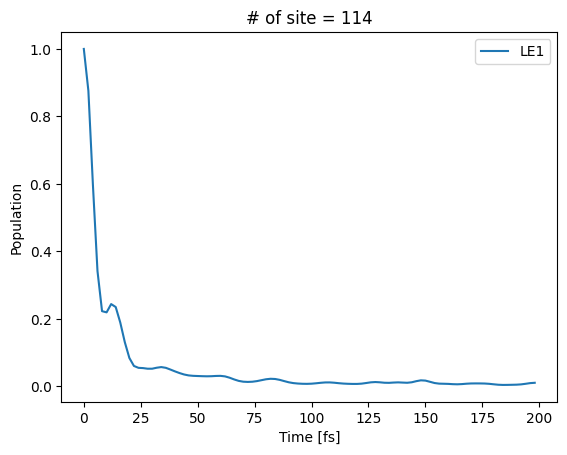

In [12]:
plt.title(f"# of site = {len(basis)}")
plt.ylabel("Population")
plt.xlabel("Time [fs]")
plt.plot(time_data, density_data_real[:, 0, 0], label="LE1")
plt.legend()
plt.show()

shape: (100, 28)
┌───────┬──────────┬──────────┬──────────┬───┬───────────┬──────────┬──────────┬───────────┐
│ time  ┆ N0       ┆ N1       ┆ N2       ┆ … ┆ N23       ┆ N24      ┆ N25      ┆ column_28 │
│ ---   ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---      ┆ ---      ┆ ---       │
│ f64   ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64      ┆ f64      ┆ str       │
╞═══════╪══════════╪══════════╪══════════╪═══╪═══════════╪══════════╪══════════╪═══════════╡
│ 0.0   ┆ 1.0      ┆ 0.0      ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ null      │
│ 2.0   ┆ 0.876045 ┆ 0.119821 ┆ 0.004072 ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ null      │
│ 4.0   ┆ 0.596038 ┆ 0.349781 ┆ 0.050875 ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ null      │
│ 6.0   ┆ 0.341647 ┆ 0.460944 ┆ 0.169318 ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ null      │
│ 8.0   ┆ 0.222853 ┆ 0.38094  ┆ 0.291616 ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ null      │
│ …     ┆ …        ┆ …        ┆ …        ┆ … ┆ …     

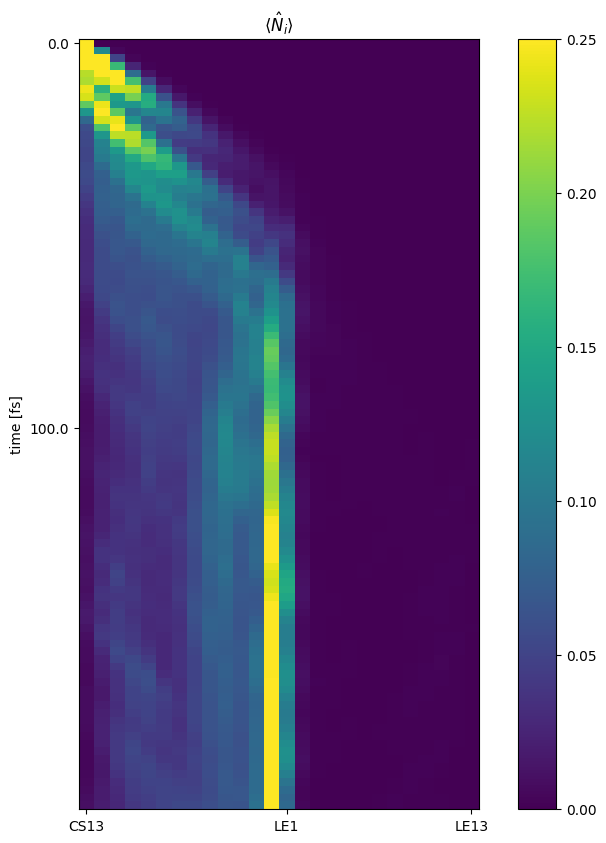

In [14]:
import re

import polars as pl

path = f"{jobname}_prop/expectations.dat"
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)

    columns.pop(2)
    
    columns = [columns[1]] + columns[2:]

    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns},
)

print(df)

plt.figure(figsize=(10, 10))
plt.xticks([0, 13, 25], ["CS13", "LE1", "LE13"])
plt.yticks(np.arange(len(df))[::50], df["time"][::50])
plt.imshow(df[columns[1:]], aspect=0.5, vmin=0.0, vmax=0.25)
plt.colorbar()
plt.ylabel("time [fs]")
plt.title(r"$\langle \hat{N}_i \rangle$")
plt.savefig("Model_B.png")
plt.show()